In [1]:
#import required libraries, note you need the GMT package installed at
#the system level to support pygmt 
import pygmt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def pgd(
        mag_w,
        distance_km,
        *,
        depth=0,
        method='Melgar2D_2015'):
    """
    pgd Calculates expected peak ground displacment based on hypo-central
    distance and Mw. PGD is defined as sqrt(x^2+y^2+z^2) for all methods
    except Melgar2D_2015, where it is sqrt(x^2+y^2).
    Distance units are in km.
    pgd is returned in cm.

    Parameters
    ----------
    :param mag_w: float
        Magnitude of earthquake
    :param distance_km: float or list of floats
        distance from earthquake, assumed to be epicentral distance unless a
        depth is supplied.
    :param depth: float
        optional
        depth of earthquake in km, depth positive, default is 0 km
    :param method: string
        optional
        method used for pgd calculation, can be
        Melgar2D_2015 (default)
        Melgar3D_2015
        Crowell_2016
        Ruhl_2019 (Do not use...)
    :return:
        float or list of floats (if distance is supplied as an list), output is in cm.

    UNAVCO 2020-2022 (Mencin)
    """
    distance = np.array(distance_km)

    if method == 'Melgar2D_2015':
        a = -4.639
        b = 1.063
        c = -0.137
    elif method == 'Melgar3D_2015':
        a = -4.434
        b = 1.047
        c = -0.138
    elif method == 'Crowell_2016':
        a = -6.687
        b = 1.500
        c = -0.214
    elif method == 'Ruhl_2019':
        a = -5.919
        b = 1.009
        c = -0.145
        distance_km = distance_km*1000
    else:
        sys.exit("Invalid method, use: Melgar2D_2015 (default), Melgar3D_2015, Crowell_2016 or Ruhl_2019.")

    log_pgd = a + b * mag_w + c * mag_w * np.log10(np.sqrt(np.power(distance, 2) + np.power(depth, 2)))
    peak_ground_displacement_mm = np.float_power(10, log_pgd)

    if method == 'Ruhl_2019':
        peak_ground_displacement_mm = peak_ground_displacement_mm * 100
    else:
        peak_ground_displacement_mm = peak_ground_displacement_mm

    return peak_ground_displacement_mm

In [3]:
def get_distance_from_mw(
                        mag_w,
                        *,
                        pgd_threshold=1.0,
                        method='Melgar2D_2015'):
    """
    get_distance_from_mw Calculates distance that given peak ground displacement would occur, based on
    hypo-central distance and Mw. PGD is defined as sqrt(x^2+y^2+z^2) for all methods except Melgar2D_2015,
    where it is sqrt(x^2+y^2).
    pgd units in cm.
    Distance units are in km.


    :param mag_w:
        Magnitude of earthquake
    :param pgd_threshold:
        expected pgd (cm).
    :param method:
        optional
        method used for pgd calculation, can be
        Melgar2D_2015 (default)
        Melgar3D_2015
        Crowell_2016
        Ruhl_2019
    :return:
        distance (km) that expected pgd (cm) would occur.

    UNAVCO 2020 (Mencin, based on Hodgkinson)
    Fixed log->log10 bug, Mencin, 2022
    """

    if method == 'Melgar2D_2015':
        a = -4.639
        b = 1.063
        c = -0.137
    elif method == 'Melgar3D_2015':
        a = -4.434
        b = 1.047
        c = -0.138
    elif method == 'Crowell_2016':
        a = -6.687
        b = 1.500
        c = -0.214
    elif method == 'Ruhl_2019':
        a = -5.919
        b = 1.009
        c = -0.145
        # This method uses meters
        pgd_threshold=pgd_threshold*.01
    else:
        sys.exit("Invalid method, use: Melgar2D_2015 (default), Melgar3D_2015, Crowell_2016 or Ruhl_2019.")

    radius = np.power(10, (np.log10(pgd_threshold) - a - b * mag_w) / (c * mag_w))

    return radius

In [4]:
#temp = get_distance_from_mw(6.5,pgd_threshold=1.0)
temp = pgd(8.0,get_distance_from_mw(8.0,pgd_threshold=2.0))
temp

2.0000000000000004

Text(153.25257542919923, 13.0, 'Detection Radius')

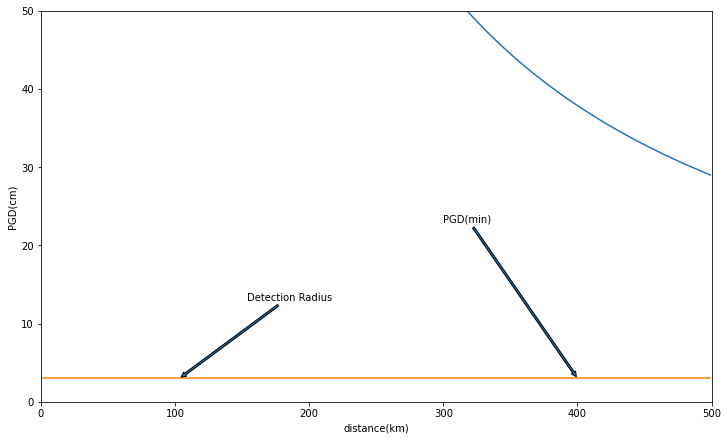

In [6]:
noise = 3.0
max_dist = 500
mag = 8.8
distance = np.arange(1,max_dist,1)
pgd_threshold = np.linspace(noise,noise,num=max_dist-1)
pgd_pred = pgd(mag,distance)
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')
plt.ylim([0, 50])
plt.xlim([0, max_dist])
ax.plot(distance,pgd_pred)
ax.plot(distance,pgd_threshold)
ax.set_xlabel('distance(km)')
ax.set_ylabel('PGD(cm)')
dist = get_distance_from_mw(6.5,pgd_threshold=noise)
ax.annotate('PGD', xy=(50, pgd(mag,50)), xytext=(100, noise+30), arrowprops=dict(arrowstyle='Simple'))
ax.annotate('PGD(min)', xy=(400, noise), xytext=(300, noise+20), arrowprops=dict(arrowstyle='Simple'))
ax.annotate('Detection Radius', xy=(get_distance_from_mw(6.5,pgd_threshold=noise), noise), xytext=(get_distance_from_mw(6.5,pgd_threshold=noise)+50, noise+10), arrowprops=dict(arrowstyle='Simple'))

In [81]:
fig.savefig('PGD_example.png',format='png')